In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

In [2]:
def load_and_prepare_data():
    """
    Load and prepare the dataset for analysis
    """
    # Load datasets
    customers = pd.read_csv('data/Customers.csv')
    products = pd.read_csv('data/Products.csv')
    transactions = pd.read_csv('data/Transactions.csv')
    
    # Convert dates to datetime
    customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
    transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
    
    return customers, products, transactions

customers, products, transactions = load_and_prepare_data()

In [3]:
def create_simple_features(customers, transactions, products):

    # RFM Analysis

    # Recency
    max_date = transactions['TransactionDate'].max()
    last_purchase = transactions.groupby('CustomerID')['TransactionDate'].max()
    recency = (max_date - last_purchase).dt.days
    
    # Frequency
    frequency = transactions.groupby('CustomerID').size()
    
    # Monetary
    monetary = transactions.groupby('CustomerID')['TotalValue'].sum()
    
    # Average order value
    avg_order = transactions.groupby('CustomerID')['TotalValue'].mean()
    
    # Region (simple binary features)
    region_dummies = pd.get_dummies(customers.set_index('CustomerID')['Region'])
    
    # Combine features
    features = pd.DataFrame({
        'Recency': recency,
        'Frequency': frequency,
        'Monetary': monetary,
        'AvgOrderValue': avg_order
    })
    
    # Add region
    features = features.join(region_dummies)
    
    # Reset index to make CustomerID a column
    features = features.reset_index()
    
    return features


customer_features = create_simple_features(customers, transactions, products)

In [4]:
from sklearn.preprocessing import StandardScaler

# Drop CustomerID as it's not a feature for clustering
features = customer_features.drop('CustomerID', axis=1)
feature_names = features.columns

standard_scaler = StandardScaler()
scaled_features = standard_scaler.fit_transform(features)

In [5]:
def find_optimal_clusters(features, max_clusters=10):
    """
    Find optimal number of clusters using the elbow method and DB Index
    """
    K = range(2, max_clusters + 1)
    db_scores = []
    silhouette_scores = []
    ch_scores = []
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(features)
        
        # Calculate metrics
        db_scores.append(davies_bouldin_score(features, labels))
        silhouette_scores.append(silhouette_score(features, labels))
        ch_scores.append(calinski_harabasz_score(features, labels))
    
    return K, db_scores, silhouette_scores, ch_scores

# Find optimal clusters
K, db_scores, silhouette_scores, ch_scores = find_optimal_clusters(scaled_features)

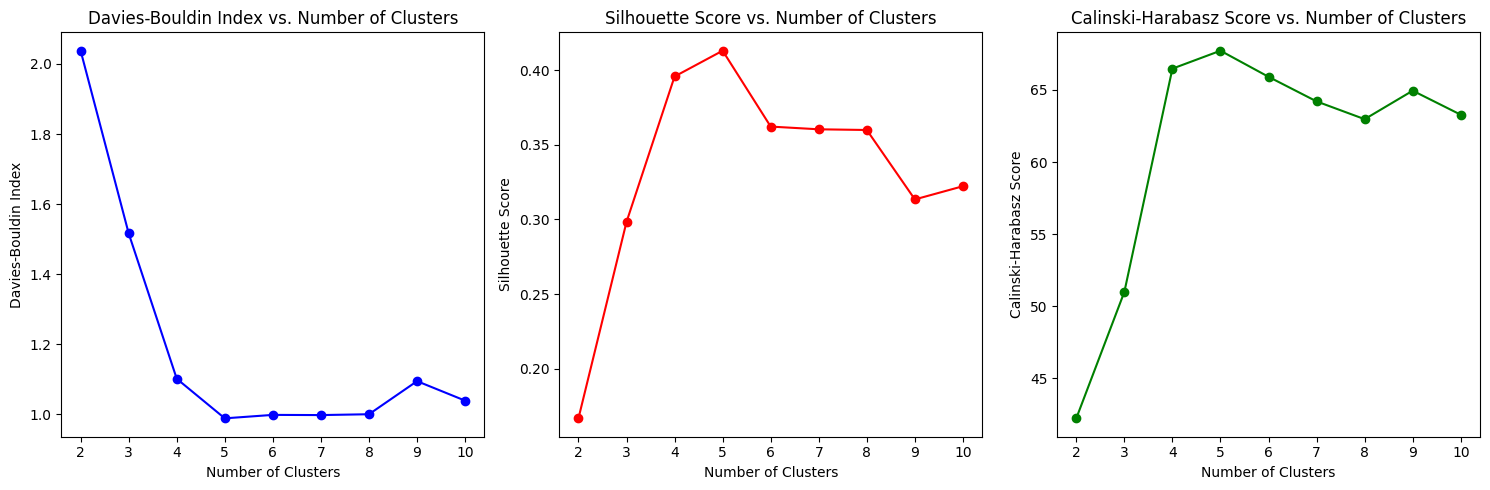

In [6]:
# Plot clustering metrics
plt.figure(figsize=(15, 5))

# DB Index
plt.subplot(1, 3, 1)
plt.plot(K, db_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs. Number of Clusters')

# Silhouette Score
plt.subplot(1, 3, 2)
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')

# Calinski-Harabasz Score
plt.subplot(1, 3, 3)
plt.plot(K, ch_scores, 'go-')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score vs. Number of Clusters')

plt.tight_layout()
plt.show()


Optimal number of clusters: 5


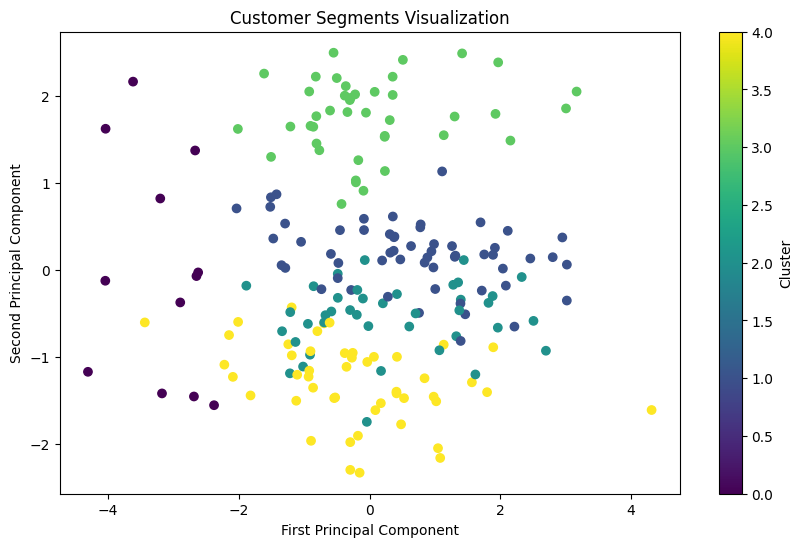

In [7]:
# Select optimal number of clusters (minimum DB Index)
optimal_k = K[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Perform final clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(scaled_features)

# Visualize clusters
from sklearn.decomposition import PCA

# PCA for dimensionality reduction
pca = PCA(n_components=2)
features_2d = pca.fit_transform(scaled_features)

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Customer Segments Visualization')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [8]:
report = {
    'Number of Clusters': optimal_k,
    'Davies-Bouldin Index': min(db_scores),
    'Silhouette Score': silhouette_scores[np.argmin(db_scores)],
    'Calinski-Harabasz Score': ch_scores[np.argmin(db_scores)]
}

# Display the report
pd.DataFrame([report])

,Number of Clusters,Davies-Bouldin Index,Silhouette Score,Calinski-Harabasz Score
0,5,0.988323,0.413089,67.725235
